In [1]:
import datasets

apps = datasets.load_dataset("codeparrot/apps", split="test")
features: [
    "problem_id",
    "question",
    "solutions",
    "input_output",
    "difficulty",
    "url",
    "starter_code",
]

/home/duncan/anaconda3/envs/expecto/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import matplotlib.pyplot as plt

added_apps = apps.add_column(
    "number_of_testcases",
    [len(json.loads(io)["inputs"]) for io in apps["input_output"]],
)

In [3]:
filtered_apps = added_apps.filter(lambda x: x["number_of_testcases"] > 25)

In [4]:
# Groupby difficult level
for difficulty in set(filtered_apps["difficulty"]):
    difficulty_apps = filtered_apps.filter(lambda x: x["difficulty"] == difficulty)
    print(f"Difficulty: {difficulty}")
    print(f"Number of apps: {len(difficulty_apps)}")


Difficulty: introductory
Number of apps: 101
Difficulty: competition
Number of apps: 240
Difficulty: interview
Number of apps: 1047


In [ ]:
import re
import requests
from typing import Optional, Dict, Any

CF_API_BASE = "https://codeforces.com/api"

_problem_url_re = re.compile(
    r"^https?://codeforces\.com/problemset/problem/(?P<contestId>\d+)/(?P<index>[A-Za-z0-9]+)$"
)


class CFAPIError(Exception):
    pass


def parse_cf_problem_url(url: str) -> Dict[str, Any]:
    m = _problem_url_re.match(url.strip())
    if not m:
        raise ValueError(
            "Unsupported URL format for Codeforces problemset/problem/{contestId}/{index}"
        )
    contest_id = int(m.group("contestId"))
    index = m.group("index").upper()
    return {"contestId": contest_id, "index": index}


def fetch_cf_problem_info(
    url: str, timeout: float = 10.0, session: Optional[requests.Session] = None
) -> Dict[str, Any]:
    """
    Parse a Codeforces problem URL like:
      https://codeforces.com/problemset/problem/1101/B
    and return problem metadata using official Codeforces API.

    Returns keys: contestId, index, name, rating (optional), tags, points (optional),
                  type, url, contest_url.
    """
    meta = parse_cf_problem_url(url)
    contest_id = meta["contestId"]
    index = meta["index"]

    s = session or requests.Session()

    # 1) Try contest.standings (small payload if we ask minimal rows)
    standings_url = f"{CF_API_BASE}/contest.standings"
    try:
        r = s.get(
            standings_url,
            params={"contestId": contest_id, "from": 1, "count": 1},
            timeout=timeout,
        )
        data = r.json()
        if data.get("status") == "OK":
            problems = data["result"].get("problems", [])
            prob = next((p for p in problems if p.get("index") == index), None)
            if prob:
                return {
                    "contestId": contest_id,
                    "index": index,
                    "name": prob.get("name"),
                    "rating": prob.get("rating"),
                    "tags": prob.get("tags", []),
                    "points": prob.get("points"),
                    "type": prob.get("type"),
                    "url": url,
                    "contest_url": f"https://codeforces.com/contest/{contest_id}",
                }
    except requests.RequestException as e:
        # fall through to backup
        pass

    # 2) Fallback: problemset.problems (bigger payload; filter locally)
    problems_url = f"{CF_API_BASE}/problemset.problems"
    try:
        r = s.get(problems_url, timeout=timeout)
        data = r.json()
        if data.get("status") != "OK":
            raise CFAPIError(
                data.get("comment", "Unknown error from problemset.problems")
            )
        for p in data["result"]["problems"]:
            if p.get("contestId") == contest_id and p.get("index") == index:
                return {
                    "contestId": contest_id,
                    "index": index,
                    "name": p.get("name"),
                    "rating": p.get("rating"),
                    "tags": p.get("tags", []),
                    "points": p.get("points"),
                    "type": p.get("type"),
                    "url": url,
                    "contest_url": f"https://codeforces.com/contest/{contest_id}",
                }
        raise CFAPIError("Problem not found in problemset.problems")
    except requests.RequestException as e:
        raise CFAPIError(f"Network error: {e}") from e

{'contestId': 1101, 'index': 'B', 'name': 'Accordion', 'rating': 1300, 'tags': ['greedy', 'implementation'], 'points': None, 'type': 'PROGRAMMING', 'url': 'https://codeforces.com/problemset/problem/1101/B', 'contest_url': 'https://codeforces.com/contest/1101'}


In [12]:
from collections import Counter

c = Counter()

for url in filtered_apps["url"]:
    try:
        info = fetch_cf_problem_info(url)
        for tag in info["tags"]:
            c[tag] += 1
    except Exception as e:
        print(f"Error fetching info for {url}: {e}")

print(c)


Error fetching info for https://atcoder.jp/contests/abc168/tasks/abc168_f: Unsupported URL format for Codeforces problemset/problem/{contestId}/{index}
Error fetching info for https://atcoder.jp/contests/abc136/tasks/abc136_e: Unsupported URL format for Codeforces problemset/problem/{contestId}/{index}
Error fetching info for https://atcoder.jp/contests/abc141/tasks/abc141_e: Unsupported URL format for Codeforces problemset/problem/{contestId}/{index}
Error fetching info for https://atcoder.jp/contests/abc157/tasks/abc157_f: Unsupported URL format for Codeforces problemset/problem/{contestId}/{index}
Error fetching info for https://atcoder.jp/contests/abc144/tasks/abc144_f: Unsupported URL format for Codeforces problemset/problem/{contestId}/{index}
Error fetching info for https://atcoder.jp/contests/arc105/tasks/arc105_c: Unsupported URL format for Codeforces problemset/problem/{contestId}/{index}
Error fetching info for https://atcoder.jp/contests/abc137/tasks/abc137_e: Unsupported U

In [ ]:
distribution = {
    "implementation": 459,
    "math": 336,
    "greedy": 259,
    "brute force": 207,
    "constructive algorithms": 130,
    "dp": 125,
    "number theory": 89,
    "strings": 77,
    "binary search": 71,
    "sortings": 70,
    "graphs": 46,
    "combinatorics": 42,
    "data structures": 41,
    "dfs and similar": 39,
    "*special": 35,
    "geometry": 34,
    "two pointers": 33,
    "bitmasks": 26,
    "trees": 14,
    "games": 13,
    "shortest paths": 13,
    "probabilities": 10,
    "dsu": 8,
    "matrices": 6,
    "divide and conquer": 5,
    "flows": 5,
    "meet-in-the-middle": 5,
    "hashing": 5,
    "ternary search": 4,
    "expression parsing": 4,
    "graph matchings": 3,
    "chinese remainder theorem": 1,
    "fft": 1,
}

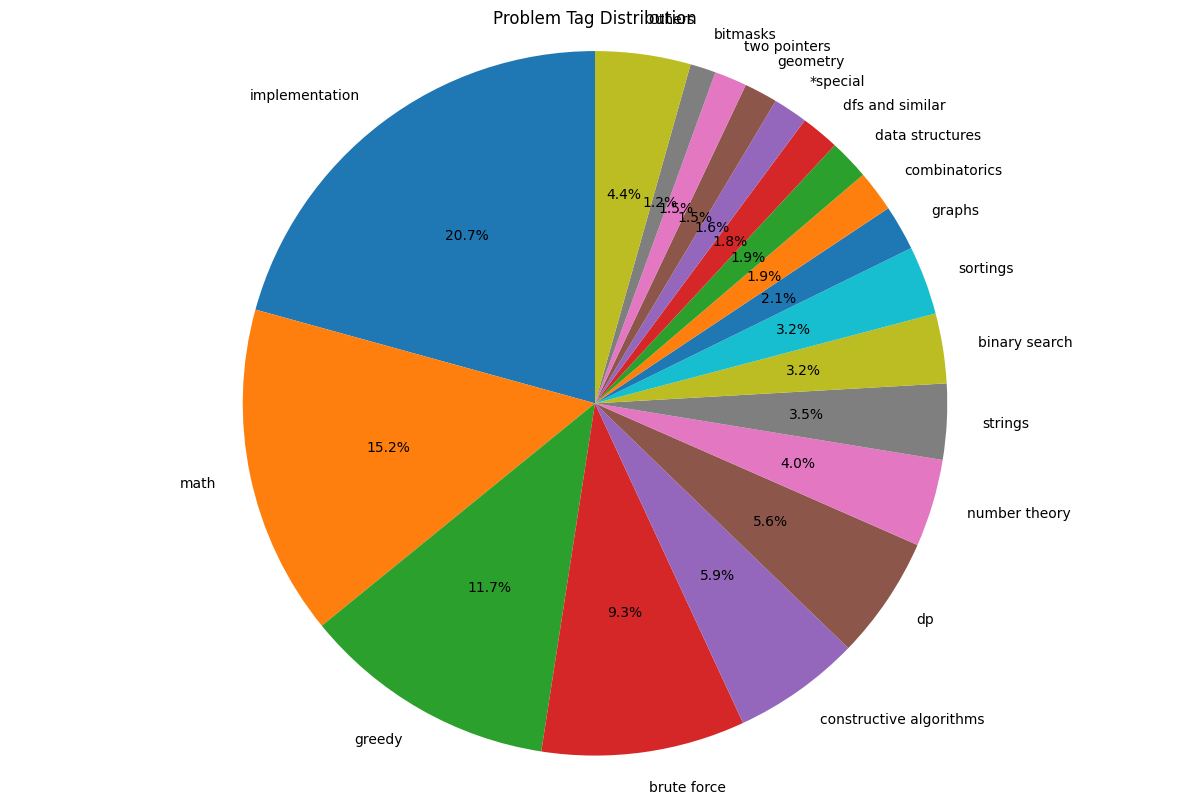

In [ ]:
import matplotlib.pyplot as plt

# Group smaller categories into "Others"
threshold = 20  # Categories with count less than this will be grouped as "Others"
main_categories = {}
others_count = 0

for tag, count in distribution.items():
    if count >= threshold:
        main_categories[tag] = count
    else:
        others_count += count

if others_count > 0:
    main_categories["Others"] = others_count

# Create pie chart for the distribution
plt.figure(figsize=(12, 8))
plt.pie(
    main_categories.values(),
    labels=main_categories.keys(),
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Problem Tag Distribution")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()
